In [1]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 49.8 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.ndimage import uniform_filter1d
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.stats import linregress
from plot_utils import download_file, extract_tar_gz, combine_ascii_files, maxc, azimuthal_equidistant_projection
import pyproj
colors = ["#5F0F40","#3D5A80","#6A994E","#E76F51","#006D77","#FFB703","#2C699A","#BC4749","#F77F00","#D1495B","#386641"]

In [3]:
# Define the URL and the local filename
url = "https://scedc.caltech.edu/ftp/catalogs/SCEC_DC/SCEDC_catalogs.tar.gz"
local_filename = "SCEDC_catalogs.tar.gz"
extract_path = "./"

# Download and extract the file
download_file(url, local_filename)
extract_tar_gz(local_filename, extract_path)
combine_ascii_files('./raw')

Downloaded SCEDC_catalogs.tar.gz
Extracted to ./
final file shape:  (900823, 12)
Merged dataset saved successfully as a CSV file.


In [4]:
raw_df = pd.read_csv("raw/SCEDC_catalog.csv")
raw_df.head()

,ET,GT,magnitude,M,latitude,longitude,DEPTH,Q,id,NPH,NGRM,time
0,eq,l,2.26,l,33.820,-117.985,6.0,D,3359497,6,0,1933-01-01 13:31:30.270
1,eq,l,2.09,l,33.831,-118.145,6.0,C,3359499,5,0,1933-01-01 22:45:24.120
2,eq,l,2.34,h,33.604,-116.768,6.0,D,3359503,4,0,1933-01-03 04:45:39.150
3,eq,l,2.12,h,33.912,-116.960,6.0,D,3359504,4,0,1933-01-03 12:39:12.210
4,eq,l,1.38,h,34.404,-118.371,6.0,D,3361946,5,0,1933-01-03 22:40:26.950


In [5]:
print(f"Number of events present in the raw dataframe: {len(raw_df)}")

Number of events present in the raw dataframe: 900823


In [6]:
raw_df['time'] = pd.to_datetime(raw_df['time'])
raw_df.sort_values('time', inplace=True)
raw_df.rename(columns={'DEPTH':'depth'}, inplace=True)
raw_df = raw_df[['time','magnitude','depth','longitude','latitude']].copy()
raw_df.reset_index(drop=True, inplace=True)
raw_df

,time,magnitude,depth,longitude,latitude
0,1932-01-01 23:52:07.870,0.00,6.0,-117.993,34.130
1,1932-01-02 16:42:43.680,2.73,6.0,-117.645,33.903
2,1932-01-03 17:58:10.010,3.00,6.0,-116.000,32.000
3,1932-01-04 21:30:00.960,2.00,6.0,-117.494,33.771
4,1932-01-05 02:37:27.960,1.50,6.0,-118.442,33.559
...,...,...,...,...,...
900818,2025-08-18 06:21:11.210,1.22,13.6,-117.230,33.969
900819,2025-08-18 06:26:59.090,0.84,3.1,-116.364,33.016
900820,2025-08-18 06:46:28.700,0.26,6.0,-116.716,33.541
900821,2025-08-18 07:10:29.610,1.05,3.3,-117.216,34.103


In [7]:
raw_df.isna().sum()

,0
time,0
magnitude,0
depth,0
longitude,0
latitude,0


In [8]:
raw_df.describe()

,time,magnitude,depth,longitude,latitude
count,900823,900823.000000,900823.000000,900823.000000,900823.000000
mean,2002-09-23 08:48:56.328264704,1.418179,6.546488,-117.065595,34.343849
min,1932-01-01 23:52:07.870000,0.000000,-2.600000,-122.000000,32.000000
25%,1992-07-13 18:26:46.015000064,0.920000,3.000000,-117.716000,33.485000
50%,2002-12-15 10:14:30.960000,1.350000,5.800000,-116.866000,34.115000
75%,2016-09-02 05:07:23.249999872,1.820000,9.700000,-116.397000,35.609000
max,2025-08-18 07:11:16.560000,7.500000,51.100000,-114.000000,37.000000
std,NaN,0.698776,4.832028,1.014881,1.142344


In [9]:
raw_df.dtypes

,0
time,datetime64[ns]
magnitude,float64
depth,float64
longitude,float64
latitude,float64


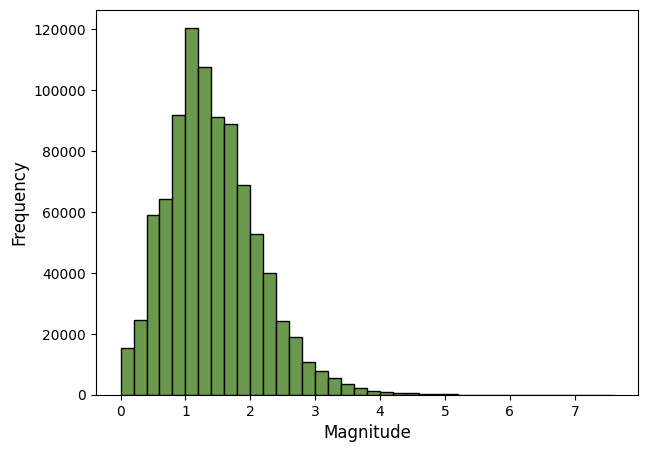

In [10]:
bins = np.arange(raw_df['magnitude'].min(), raw_df['magnitude'].max() + 0.2, 0.2)

plt.figure(figsize=(7, 5))
plt.hist(raw_df['magnitude'], bins=bins, color=colors[2], edgecolor='black')
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

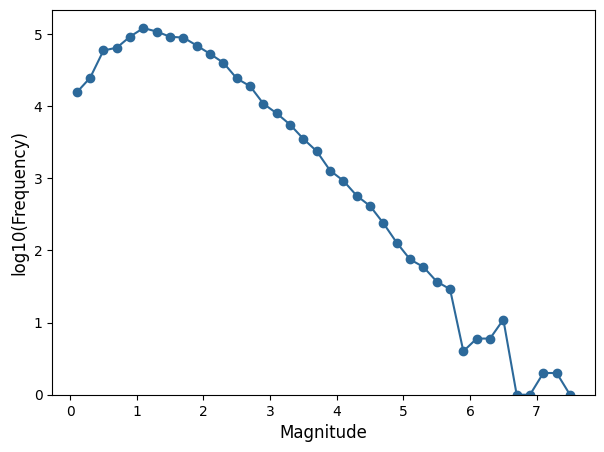

In [11]:
counts, bin_edges = np.histogram(raw_df['magnitude'], bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
non_zero_indices = counts > 0

plt.figure(figsize=(7, 5))
plt.plot(bin_centers[non_zero_indices], np.log10(counts[non_zero_indices]), 'o-', color=colors[6])
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('log10(Frequency)', fontsize=12)
plt.ylim(bottom=0)
plt.show()

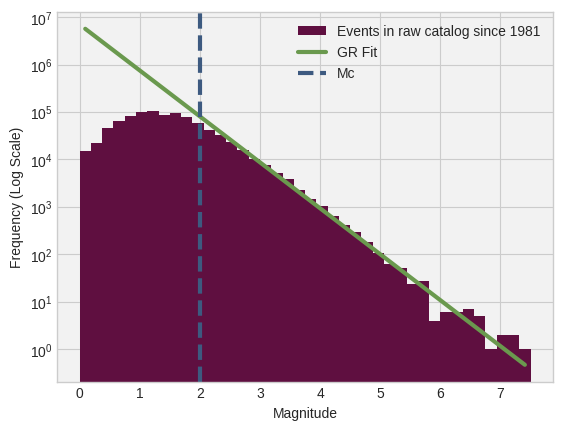

In [33]:
# plotting params
plt.figure()
plt.gca().set_facecolor((0.95, 0.95, 0.95))
bins = 40
linew = 3

# histogram
hist, bins = np.histogram(raw_df['magnitude'], bins=bins)
log_hist = np.log10(hist[hist > 0])
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_centers = bin_centers[hist > 0]

plt.hist(raw_df['magnitude'], bins=bins, log=True, alpha=1, color=colors[0], label='Events in raw catalog since 1981')
plt.xlabel(r'Magnitude')
plt.ylabel('Frequency (Log Scale)')

# Fit a GR line to the log-transformed histogram data
mag_bin = 0.05
mask = (bin_centers >= 2) & (bin_centers<=7)
slope, intercept, r_value, p_value, std_err = linregress(bin_centers[mask], log_hist[mask])
plt.plot(bin_centers, 10**(slope * bin_centers + intercept), 'r-',color = colors[2], label='GR Fit',linewidth=linew)
plt.axvline(x=2.0, color=colors[1], linestyle='--', label='Mc',linewidth=linew)

plt.legend()
plt.show()

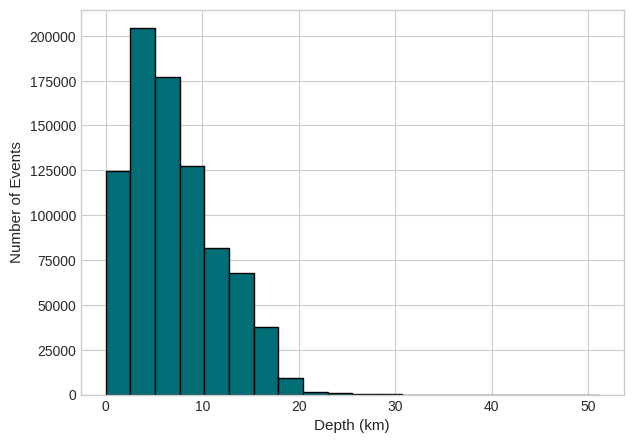

In [31]:
shallow_events = raw_df[(raw_df['depth'] >= 0) & (raw_df['depth'] < 70)]

plt.figure(figsize=(7, 5))
plt.hist(shallow_events['depth'], bins=20, edgecolor='black', color=colors[4])
plt.xlabel('Depth (km)', fontsize=11)
plt.ylabel('Number of Events', fontsize=11)
plt.grid(True, zorder=0)
plt.show()

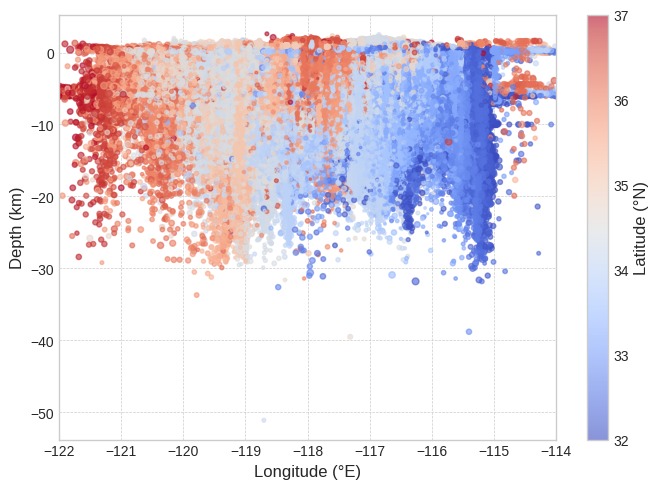

In [14]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(7, 5))

scatter = ax.scatter(raw_df['longitude'], -raw_df['depth'], c=raw_df['latitude'], cmap='coolwarm', s=raw_df['magnitude'] * 5, alpha=0.6)
ax.set_xlabel('Longitude (°E)', fontsize=12)
ax.set_ylabel('Depth (km)', fontsize=12)
ax.set_xlim(raw_df['longitude'].min(), raw_df['longitude'].max())
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Latitude (°N)', fontsize=12)
plt.tight_layout()
plt.show()

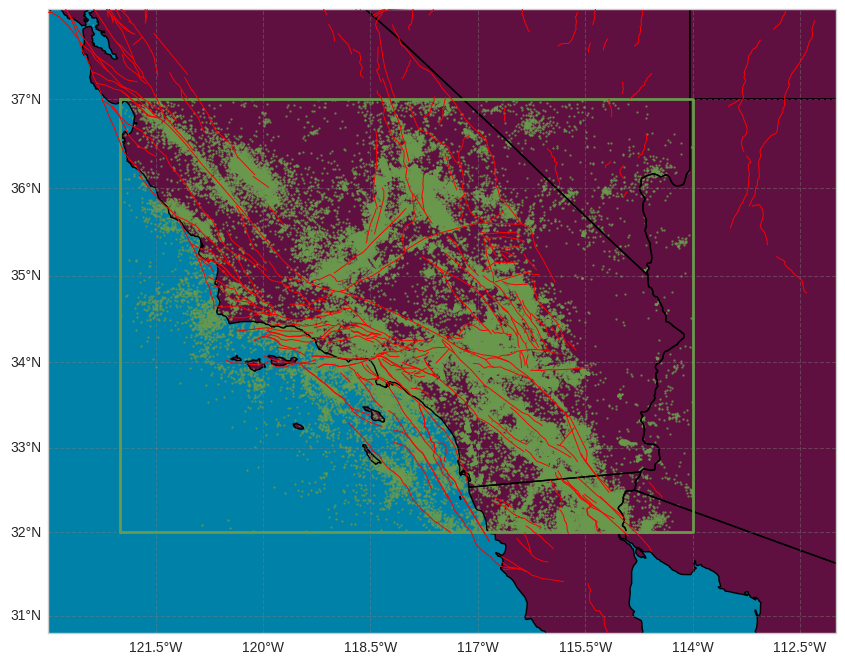

In [32]:
# Read the GEM fault data
gdf = gpd.read_file('gem_active_faults.gpkg')
faults = gdf.geometry

# Filter the GeoDataFrame to include only geometries within the specified extent
max_lat, min_lat, max_lon, min_lon = 38, 30.79, -110, -130
filtered_gdf = gdf.cx[min_lon:max_lon, min_lat:max_lat]

# Extract the geometry of the faults within the specified extent
faults_within_extent = filtered_gdf.geometry

# Create a figure with Cartopy
fig = plt.figure(figsize=(10.5, 8.1))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([-123, -112, 30.79, 38], crs=ccrs.PlateCarree())

# Add colored land and ocean
ax.add_feature(cfeature.LAND, facecolor="#5F0F40")
ax.add_feature(cfeature.OCEAN, facecolor="#0081A7")
ax.add_feature(cfeature.STATES, edgecolor='black')

# Plot the faults
for geom in faults_within_extent:
    ax.plot(geom.xy[0], geom.xy[1], color='red', transform=ccrs.PlateCarree(),zorder=10,linewidth=0.7)

# Add gridlines with customization
gl = ax.gridlines(draw_labels=True, color='gray', linestyle='--', alpha=0.4)
gl.right_labels = False
gl.top_labels = False
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

# Plot polygon
polygon_coords = np.load('SCEDC_shape.npy')
plot_polygon_coords = np.append(polygon_coords, [polygon_coords[0]], axis=0)
ax.plot(plot_polygon_coords[:, 1], plot_polygon_coords[:, 0], transform=ccrs.PlateCarree(), color=colors[2], lw=2)

plot_catalog = raw_df[raw_df['magnitude']>=1.8]
# Plot events
ax.scatter(plot_catalog['longitude'], plot_catalog['latitude'], transform=ccrs.PlateCarree(), s=0.4, color=colors[2], alpha=0.8)
plt.show()

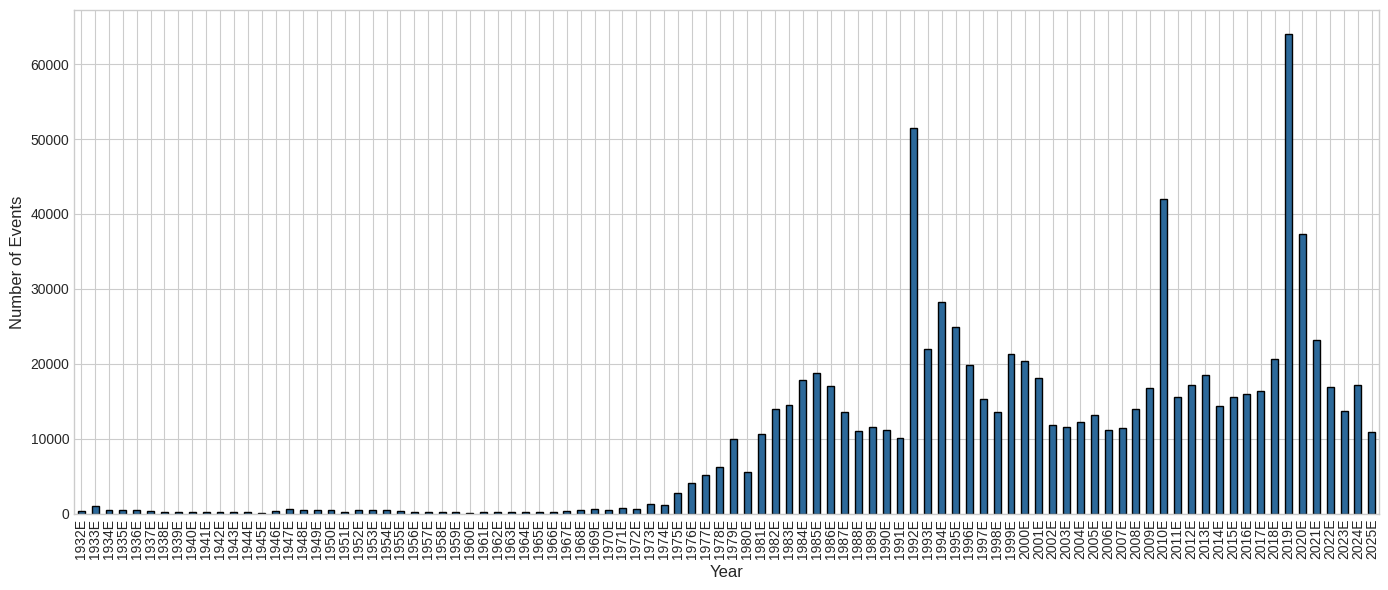

In [16]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 6))

events_per_year = raw_df.set_index('time')['magnitude'].resample('YE').count()
events_per_year.plot(kind='bar', ax=ax, color=colors[6], edgecolor='black')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Events', fontsize=12)
ax.set_xticklabels([d.strftime('%YE') for d in events_per_year.index])
plt.tight_layout()
plt.show()

In [17]:
def fmd(mag, mbin):
	"""
	Computes the frequency-magnitude distribution of earthquakes.

	Parameters:
	- mag (array-like): Array of earthquake magnitudes.
	- mbin (float): Magnitude bin size.

	Returns:
	- dict: Dictionary containing magnitude bins, cumulative counts, and non-cumulative counts.
	"""
	mag = np.array(mag)

	mi = np.arange(min(np.round(mag/mbin)*mbin), max(np.round(mag/mbin)*mbin),mbin)

	nbm = len(mi)
	cumnbmag = np.zeros(nbm)
	nbmag = np.zeros(nbm)

	for i in range(nbm):
		cumnbmag[i] = sum((mag > mi[i]-mbin/2))

	cumnbmagtmp = np.append(cumnbmag,0)
	nbmag = abs(np.ediff1d(cumnbmagtmp))

	res = {'m':mi, 'cum':cumnbmag, 'noncum':nbmag}

	return res

In [18]:
def maxc(mag, mbin):
	"""
	Determines the magnitude of completeness (Mc) from the frequency-magnitude distribution.

	Parameters:
	- mag (array-like): Array of earthquake magnitudes.
	- mbin (float): Magnitude bin size.

	Returns:
	- float: Magnitude of completeness (Mc).
	"""
	FMD = fmd(mag, mbin)

	if len(FMD['noncum'])>0:
	# if True:

		Mc = FMD['m'][np.where(FMD['noncum']==max(FMD['noncum']))[0]][0]

	else:
		Mc = None

	return Mc

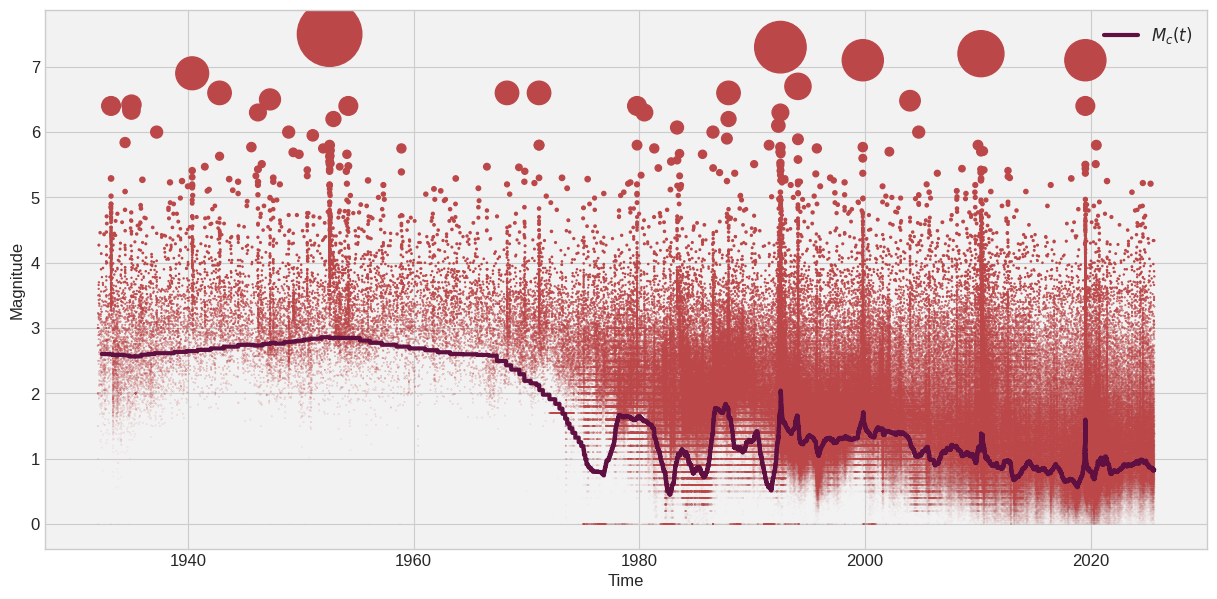

In [19]:
plt.figure(figsize=(15, 7))
plt.gca().set_facecolor((0.95, 0.95, 0.95))

# Compute M_c(t) across the raw catalog
window_size=300
nwindows = math.floor(len(raw_df['magnitude'])/window_size)

Mc_t = [0]*nwindows
mid_time = [0]*nwindows

comp_T = raw_df['time']
comp_M = raw_df['magnitude']

for i in range(nwindows):

    mid_time[i] =  pd.Timestamp(pd.Series(comp_T[i*window_size:(i+1)*window_size]).mean())

    window = comp_M[i*window_size:(i+1)*window_size]
    Mc_t[i] = maxc(window,0.05)

# Smooth M_c(t) for plotting
Mc_t = uniform_filter1d(Mc_t, size=40)

# Plotting
plt.step(mid_time,Mc_t,colors[0],label=r'$M_c(t)$',lw=3)
z = (9.5**raw_df['magnitude'])*0.0001
plt.scatter(raw_df['time'],raw_df['magnitude'],s=z,color =colors[7])
plt.xlabel('Time',fontsize=12)
plt.ylabel('Magnitude',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

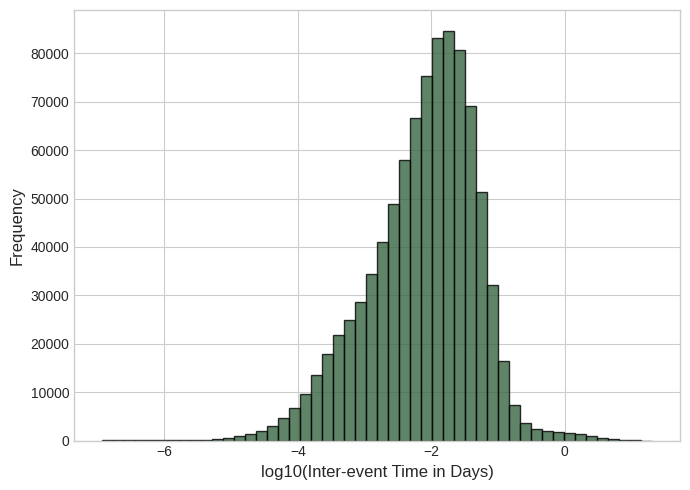

In [20]:
interevent_times = raw_df['time'].diff().dt.total_seconds() / (3600 * 24)
interevent_times = interevent_times.dropna()
log_iets = np.log10(interevent_times[interevent_times > 0])

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(log_iets, bins=50, color=colors[10], edgecolor='black', alpha=0.8)
ax.set_xlabel('log10(Inter-event Time in Days)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

In [21]:
time_start = '1985-01-01 00:00:00'
time_end = '2020-01-01 00:00:00'
catalog = raw_df[raw_df['time']>=time_start]
catalog = raw_df[raw_df['time']<time_end]
len_trunc_x = len(raw_df)
len_trunc_t = len(catalog)
print('Removed',len_trunc_x-len_trunc_t, 'events outside timewindow')

Removed 119154 events outside timewindow


In [22]:
# filter events above magnitude threshold
M_threshold = 2
catalog = catalog[catalog['magnitude']>=M_threshold]
len_trunc_m = len(catalog)
print('Removed',len_trunc_t-len_trunc_m, 'events below Magnitude Threshold')

Removed 620195 events below Magnitude Threshold


In [23]:
SOUTH_CALIFORNIA_PROJECTION = pyproj.Proj(
'+proj=utm +zone=11 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 '
'+units=m +no_defs'
)

catalog['x_utm'], catalog['y_utm'] = SOUTH_CALIFORNIA_PROJECTION(catalog['longitude'].values, catalog['latitude'].values)

In [24]:
# converting datetime to UTC format for input into the FERN model
catalog['time'] = catalog['time'].astype('int64') / 1e9

In [25]:
catalog.head()

,time,magnitude,depth,longitude,latitude,x_utm,y_utm
1,-1.199085e+09,2.73,6.0,-117.645,33.903,440367.549732,3.751588e+06
2,-1.198995e+09,3.00,6.0,-116.000,32.000,594457.463402,3.540873e+06
3,-1.198895e+09,2.00,6.0,-117.494,33.771,454257.899420,3.736875e+06
5,-1.198771e+09,2.00,6.0,-117.475,34.143,456208.233842,3.778114e+06
8,-1.198660e+09,3.00,6.0,-116.000,32.000,594457.463402,3.540873e+06


In [26]:
catalog.describe()

,time,magnitude,depth,longitude,latitude,x_utm,y_utm
count,1.614740e+05,161474.000000,161474.000000,161474.000000,161474.000000,161474.000000,1.614740e+05
mean,6.838917e+08,2.498484,5.561929,-117.057027,34.132928,495959.230806,3.777781e+06
std,5.536348e+08,0.480740,4.491805,1.386227,1.214966,127285.035209,1.350168e+05
min,-1.199085e+09,2.000000,-2.300000,-122.000000,32.000000,42934.276179,3.540436e+06
25%,4.465220e+08,2.150000,2.300000,-117.803000,33.066000,426000.549989,3.659717e+06
50%,7.109172e+08,2.360000,5.400000,-116.780000,34.108000,520269.983680,3.774316e+06
75%,1.018553e+09,2.700000,7.400000,-116.075000,34.994000,586071.577362,3.873230e+06
max,1.577824e+09,7.500000,39.500000,-114.000000,37.000000,781486.535287,4.106576e+06


In [27]:
catalog.to_csv("SCEDC_catalog.csv", index=False)